# Analyze the visual embedding space and the semantic embedding space using given categories

In [70]:
import pickle
import pandas as pd
from pathlib2 import Path

In [71]:
embeddings_dir = Path('embeddings')
labels_dir = Path('labels')

## Define useful tools and metrics

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

In [73]:
def cluster_embeddings(embeddings_array, k):
    kmeans = KMeans(n_clusters=k, random_state=699).fit(embeddings_array)

    # Get the cluster labels and centroids
    cluster_labels = kmeans.labels_
    cluster_centroids = kmeans.cluster_centers_

    return cluster_labels, cluster_centroids

In [74]:
def analyze_label_relationship(labels1, labels2):
    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(labels1, labels2)

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(labels1, labels2)

    # Calculate the Contingency Matrix (confusion matrix)
    cm = confusion_matrix(labels1, labels2)
    
    # Sum the maximum values of each row
    max_values_sum = np.sum(np.amax(cm, axis=1))
    
    # Calculate purity
    purity = max_values_sum / np.sum(cm)

    return ari, nmi, purity, cm


In [75]:
def tsne_plot(embeddings, labels, labels_index_dict):
    tsne = TSNE(n_components=2,
                learning_rate='auto',
                init='random',
                perplexity=3,
                random_state=699)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a list of unique categories and their colors
    unique_labels = list(set(labels))
    colors = colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    # Plot the t-SNE
    plt.figure(figsize=(10, 8))
    for label, color in zip(unique_labels, colors):
        filter = labels == label
        plt.scatter(embeddings_2d[filter, 0],
                    embeddings_2d[filter, 1],
                    c=[color],
                    label=labels_index_dict[label],
                    s=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [76]:
def cm_heat_plot(cm, label_index_dict):
    # Create a list of unique categories and their colors
    row_sums = cm.sum(axis=1, keepdims=True)
    normalized_cm = cm / row_sums

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_cm, annot=True, cmap='Reds', fmt='.2f', xticklabels=label_index_dict.values(), yticklabels=label_index_dict.values())
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [77]:
def analyze(labels, embeddings, label_index_dict):
    k = len(set(labels))
    print('Begin clustering with k =', k)
    cluster_labels, cluster_centroids = cluster_embeddings(embeddings, k)
    print('Clustering complete.')
    ari, nmi, purity, cm = analyze_label_relationship(labels, cluster_labels)
    
    random_labels = np.random.randint(0, k, len(labels))
    r_ari, r_nmi, r_purity, r_cm = analyze_label_relationship(labels, random_labels)
    
    print("Adjusted Rand Index:", ari, "random ones:", r_ari)
    print("Normalized Mutual Information:", nmi, "random ones:", r_nmi)
    print('Purity:', purity, "random ones:", r_purity)
    print("Contingency Matrix (confusion matrix):\n")
    
    cm_heat_plot(cm, label_index_dict)
    tsne_plot(embeddings, labels, label_index_dict)
    
    return ari, nmi, purity,  cluster_centroids, cluster_labels
    

In [78]:
def align_labels(labels_df, embeddings):
    common_hanzi = set(labels_df['Hanzi'].values).intersection(set(embeddings.keys()))
    labels = labels_df[labels_df['Hanzi'].isin(common_hanzi)]['label_index'].values
    result_embeddings = np.array([embeddings[hanzi] for hanzi in common_hanzi])
    return labels, result_embeddings

In [79]:
def create_balanced_dataset(df, label_column, samples_per_label=None):
    """
    Creates a relatively balanced dataset by sampling a specified number of samples per label.

    :param df: A pandas DataFrame containing the data.
    :param label_column: The name of the column containing the labels.
    :param samples_per_label: The number of samples to sample per label. If None, sample all available samples.
    :return: A new DataFrame containing the balanced dataset.
    """
    unique_labels = df[label_column].unique()
    dfs = []

    for label in unique_labels:
        label_df = df[df[label_column] == label]

        if samples_per_label is not None:
            label_df = label_df.sample(min(samples_per_label, len(label_df)), random_state=699)

        dfs.append(label_df)

    # Concatenate the DataFrames and shuffle the rows
    balanced_df = pd.concat(dfs).sample(frac=1, random_state=699).reset_index(drop=True)

    return balanced_df

## Analyze Visual Embeddings

In [80]:
visual_labels_df = pd.read_csv(labels_dir / 'visual_labels_cleaned.csv')
visual_labels_df.head()

,Hanzi,Structure,label_index
0,一,Unicomponent,0
1,乙,Unicomponent,0
2,二,Unicomponent,0
3,十,Unicomponent,0
4,丁,Unicomponent,0


In [81]:
visual_label_index_dict = pickle.load(open(labels_dir / 'visual_labels_index_dict.pkl', 'rb'))

### Visual embeddings

In [92]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(visual_labels_df, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: 0.0007617474177691776 random ones: -0.0005221148646092401
Normalized Mutual Information: 0.015573761381043476 random ones: 0.015559251901565343
Purity: 0.1496 random ones: 0.0984
Contingency Matrix (confusion matrix):



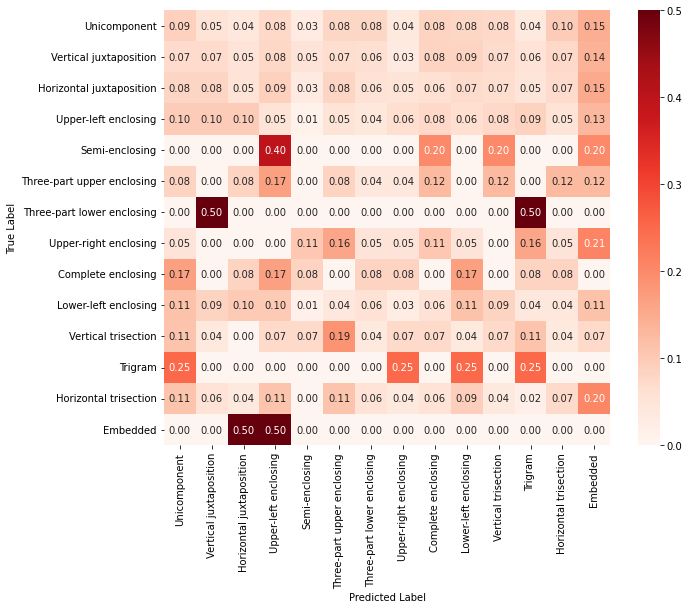

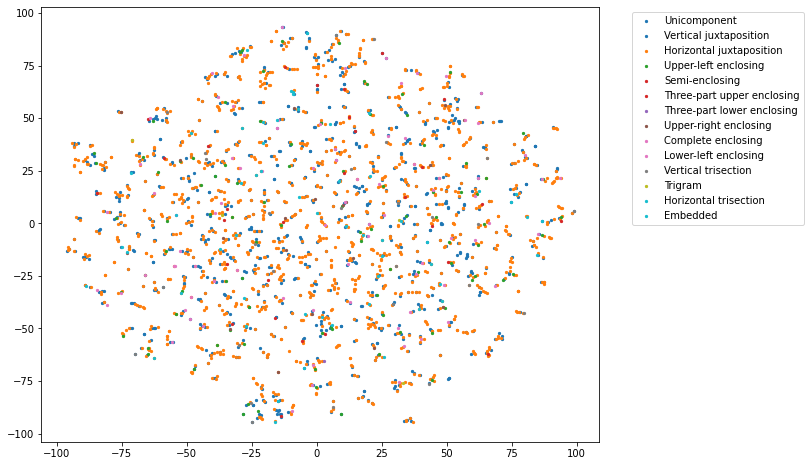

In [93]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings, visual_label_index_dict)

### Text embeddings

In [84]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(visual_labels_df, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: 0.003302166602809195 random ones: -0.0003622576595459985
Normalized Mutual Information: 0.01822185658870369 random ones: 0.016235537759913994
Purity: 0.1952 random ones: 0.0992
Contingency Matrix (confusion matrix):



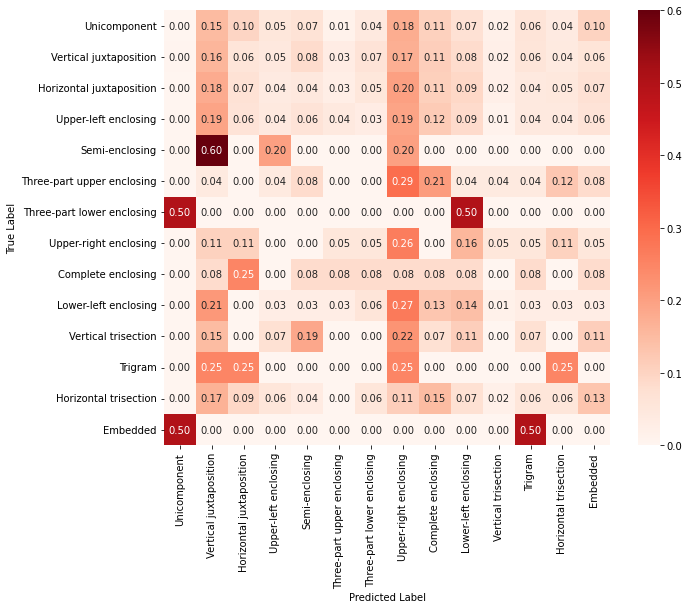

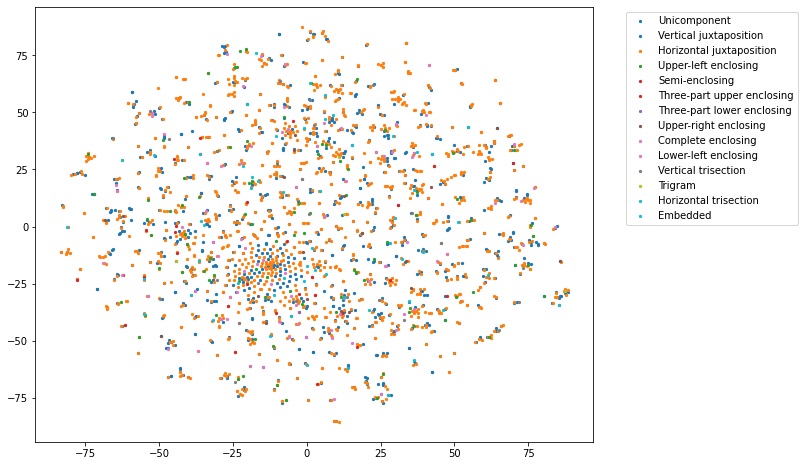

In [85]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings, visual_label_index_dict)

### balanced dataset

In [86]:
# count each label
visual_labels_df['Structure'].value_counts()

Horizontal juxtaposition      1321
Vertical juxtaposition         641
Unicomponent                   226
Upper-left enclosing            93
Lower-left enclosing            70
Horizontal trisection           54
Vertical trisection             27
Three-part upper enclosing      24
Upper-right enclosing           19
Complete enclosing              12
Semi-enclosing                   5
Trigram                          4
Three-part lower enclosing       2
Embedded                         2
Name: Structure, dtype: int64

In [87]:
balanced_df = create_balanced_dataset(visual_labels_df, 'label_index', 100)
balanced_df['Structure'].value_counts()

Unicomponent                  100
Horizontal juxtaposition      100
Vertical juxtaposition        100
Upper-left enclosing           93
Lower-left enclosing           70
Horizontal trisection          54
Vertical trisection            27
Three-part upper enclosing     24
Upper-right enclosing          19
Complete enclosing             12
Semi-enclosing                  5
Trigram                         4
Three-part lower enclosing      2
Embedded                        2
Name: Structure, dtype: int64

### visual embedding (banlanced)

In [88]:
visual_embeddings = pickle.load(open(embeddings_dir / 'visual_embeddings.pkl', 'rb'))
visual_labels, visual_embeddings = align_labels(balanced_df, visual_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.002843385129164934 random ones: 0.0029965798276507787
Normalized Mutual Information: 0.04501298460911128 random ones: 0.06418862102377433
Purity: 0.19117647058823528 random ones: 0.1437908496732026
Contingency Matrix (confusion matrix):



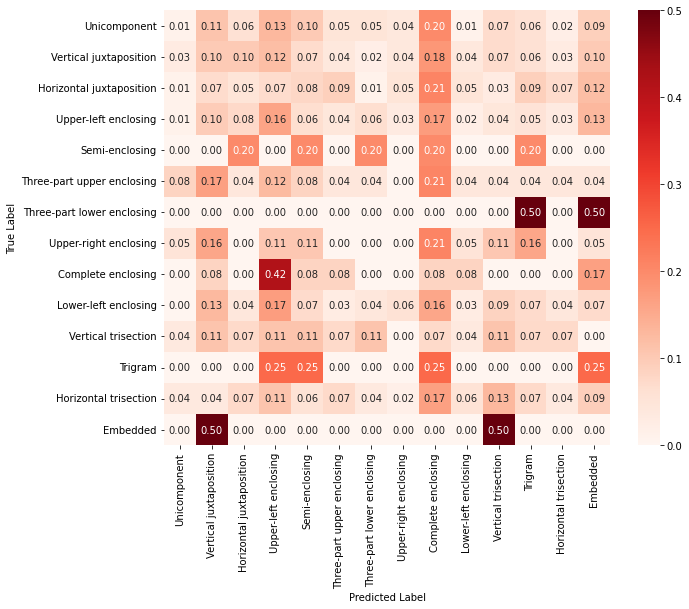

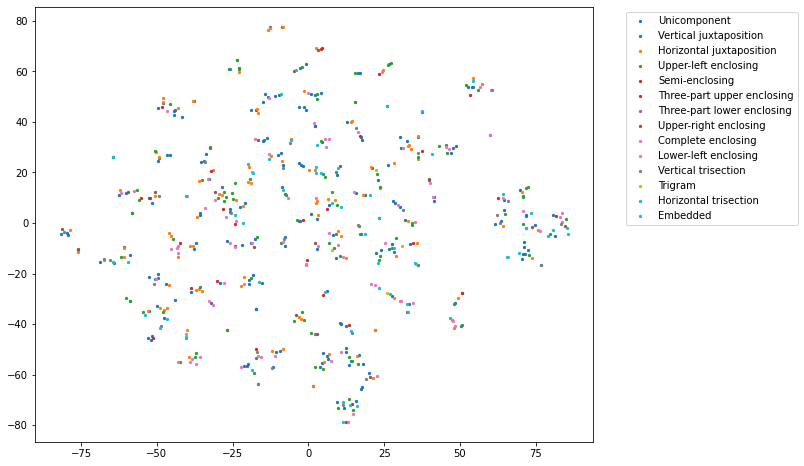

In [89]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, visual_embeddings, visual_label_index_dict)

### Text embedding (balanced)

In [90]:
text_embeddings = pickle.load(open(embeddings_dir / 'text_embeddings.pkl', 'rb'))
visual_labels, text_embeddings = align_labels(balanced_df, text_embeddings)

Begin clustering with k = 14
Clustering complete.
Adjusted Rand Index: -0.0011029603774354525 random ones: 0.0024826216536540085
Normalized Mutual Information: 0.04669156530478859 random ones: 0.06440472841799032
Purity: 0.3284313725490196 random ones: 0.1454248366013072
Contingency Matrix (confusion matrix):



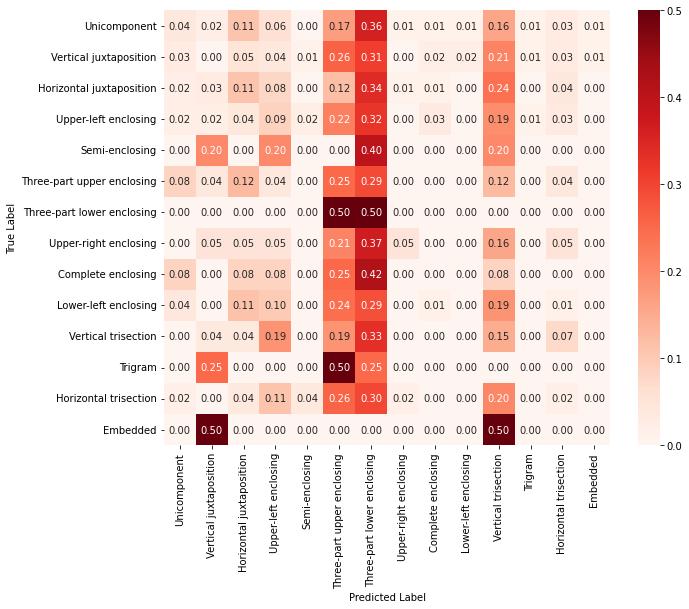

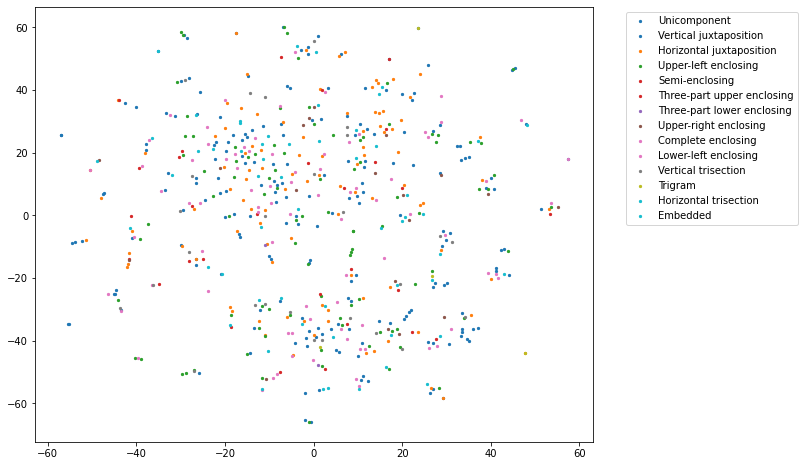

In [91]:
ari, nmi, purity, cluster_centroids, cluster_labels = analyze(visual_labels, text_embeddings, visual_label_index_dict)